# Cleaning Data

## Imports and Loads

In [121]:
import pandas as pd
import numpy as np

In [122]:
# Load datasets
raw_listings = pd.read_parquet('data/raw/listings.parquet')
raw_reviews = pd.read_parquet('data/raw/reviews.parquet')

## Listings
- Converter id para string
- filtrar somente regiao de interesse
- remover colunas nao necessarias
- explidir amenities
- ultimo review em 2025

In [123]:
listings = raw_listings.copy()

In [124]:
listings['id'] = listings['id'].astype(str)
listings['host_id'] = listings['host_id'].astype(str)

In [125]:
listings['price'] = listings['price'].str.replace('$', '').str.replace(',', '').astype(float)

Preços extremos: Mín $34 | Máx $500000 | P99 $6131
Suspeitos: 1312 muito baixos, 1614 muito altos


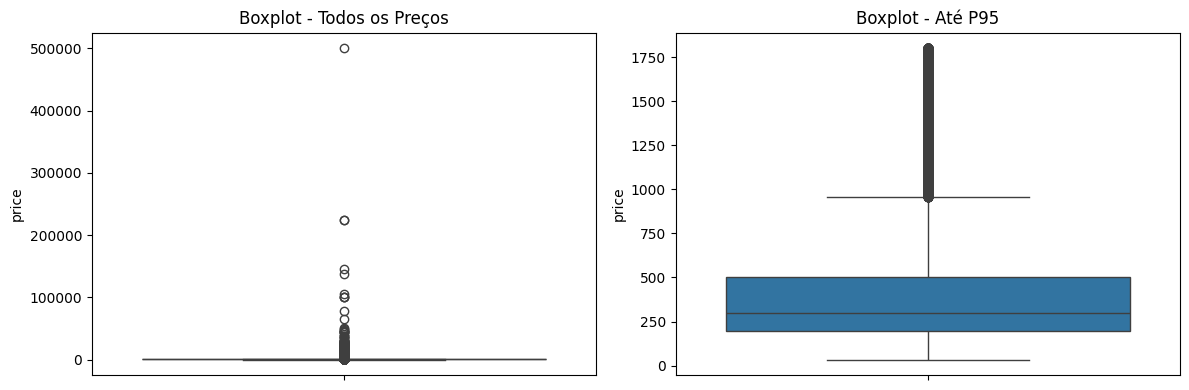

In [126]:
# Análise simples de anomalias de preço
print(f"Preços extremos: Mín ${prices.min():.0f} | Máx ${prices.max():.0f} | P99 ${prices.quantile(0.99):.0f}")
print(f"Suspeitos: {len(prices[prices < 100])} muito baixos, {len(prices[prices > 2000])} muito altos")

# Boxplot simples
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.boxplot(y=prices)
plt.title('Boxplot - Todos os Preços')

plt.subplot(1,2,2)
sns.boxplot(y=prices[prices <= prices.quantile(0.95)])
plt.title('Boxplot - Até P95')

plt.tight_layout()
plt.show()

Nao vamos mexer nos outliers aqui por que sao os imoveis de luxo, entao faz sentido manter ainda

In [127]:
listings = listings[listings['last_review'] >= '2024-01-01']

In [128]:
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.replace('%', '').astype(float)

In [129]:
listings['host_is_superhost'] = listings['host_is_superhost'].map({'t': True, 'f': False})

In [130]:
# Tratar valores NaN
listings['host_is_superhost'] = listings['host_is_superhost'].fillna(False)

/var/folders/80/0vb7fb6j0zzg0v8wfvg3_snw0000gr/T/ipykernel_32926/896374290.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  listings['host_is_superhost'] = listings['host_is_superhost'].fillna(False)


In [131]:
listings['neighbourhood_cleansed'].value_counts()

neighbourhood_cleansed
Copacabana            10567
Ipanema                2860
Barra da Tijuca        2484
Centro                 1772
Leblon                 1492
                      ...  
Galeão                    1
Complexo do Alemão        1
Turiaçú                   1
Senador Camará            1
Colégio                   1
Name: count, Length: 148, dtype: int64

In [ ]:
listings = listings[listings['neighbourhood_cleansed'].isin(['Leblon'])].reset_index(drop=True) # ['Copacabana', 'Ipanema', 'Copacabana']

In [133]:
listings['property_type'].value_counts()

property_type
Entire rental unit                    12082
Private room in rental unit            1572
Entire condo                            525
Entire loft                             368
Entire serviced apartment               233
Private room in home                     80
Entire home                              72
Private room in condo                    63
Room in aparthotel                       61
Shared room in rental unit               40
Private room in bed and breakfast        28
Shared room in guesthouse                13
Entire guest suite                       13
Private room in guesthouse               12
Private room in guest suite              11
Entire guesthouse                        10
Private room in hostel                   10
Room in hotel                             9
Private room in serviced apartment        8
Private room in casa particular           7
Private room                              6
Entire place                              6
Shared room in hos

In [134]:
listings = listings[~listings['property_type'].str.contains('Private|Shared|Room', na=False)]

In [135]:
columns_to_keep = [
    'id', 'name', 'host_id', 'host_is_superhost', 
    'neighbourhood_cleansed', 'property_type', 'amenities', 'price',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value']

In [136]:
listings = listings[columns_to_keep]

In [137]:
# Tratar amenities - converter de string para lista e explodir
import ast

def parse_amenities(amenities_str):
    try:
        return ast.literal_eval(amenities_str)
    except:
        return []

listings['amenities_list'] = listings['amenities'].apply(parse_amenities)

# Criar DataFrame explodido de amenities
amenities_exploded = listings[['id', 'amenities_list']].explode('amenities_list')
amenities_exploded = amenities_exploded[amenities_exploded['amenities_list'].notna()]
amenities_exploded.rename(columns={'amenities_list': 'amenity'}, inplace=True)

# Salvar amenities separadamente
amenities_exploded.to_csv('data/processed/amenities.csv', index=False)

print(f"Amenities mais comuns:")
print(amenities_exploded['amenity'].value_counts().head(10))

Amenities mais comuns:
amenity
Kitchen                  12989
Wifi                     12045
Hot water                10669
Dishes and silverware    10543
Bed linens               10037
Iron                      9592
Cooking basics            9575
Hangers                   9572
Microwave                 9541
Elevator                  8622
Name: count, dtype: int64


In [138]:
listings.isnull().sum()

id                               0
name                             0
host_id                          0
host_is_superhost                0
neighbourhood_cleansed           0
property_type                    0
amenities                        0
price                          894
review_scores_rating             0
review_scores_accuracy           2
review_scores_cleanliness        2
review_scores_checkin            2
review_scores_communication      2
review_scores_location           2
review_scores_value              2
amenities_list                   0
dtype: int64

In [139]:
# remover as linhas que tem NaN em algum review score
listings = listings.dropna(subset=['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                                 'review_scores_value']).reset_index(drop=True)

Vamos manter o price NaN para analises futuras

In [140]:
listings

,id,name,host_id,host_is_superhost,neighbourhood_cleansed,property_type,amenities,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,amenities_list
0,17878,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",68997,False,Copacabana,Entire condo,"[""Oven"", ""Building staff"", ""TV with standard c...",254.0,4.71,4.76,4.64,4.83,4.91,4.78,4.67,"[Oven, Building staff, TV with standard cable,..."
1,25026,Beautiful Modern Decorated Studio in Copacabana,102840,True,Copacabana,Entire rental unit,"[""Window AC unit"", ""Room-darkening shades"", ""D...",252.0,4.75,4.74,4.81,4.83,4.93,4.85,4.65,"[Window AC unit, Room-darkening shades, Dedica..."
2,35764,COPACABANA SEA BREEZE - RIO - 25 X Superhost,153691,True,Copacabana,Entire loft,"[""Building staff"", ""Bed linens"", ""Heating"", ""P...",190.0,4.91,4.94,4.92,4.97,4.95,4.95,4.89,"[Building staff, Bed linens, Heating, Paid par..."
3,48305,Bright 6bed Penthouse Seconds from Beach,70933,True,Ipanema,Entire rental unit,"[""Pack \u2019n play/Travel crib"", ""Private pat...",2239.0,4.77,4.74,4.73,4.84,4.84,4.95,4.59,"[Pack ’n play/Travel crib, Private patio or ba..."
4,48901,Extra large 4BD 3BT on the AtlanticAve. Copaca...,222884,False,Copacabana,Entire rental unit,"[""Microwave"", ""Dedicated workspace"", ""Hot wate...",743.0,4.63,4.67,4.42,4.88,4.83,4.94,4.60,"[Microwave, Dedicated workspace, Hot water, Ki..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13316,1445922773284650234,Apartamento Copacabana 1 quarto.,548464749,False,Copacabana,Entire rental unit,"[""Exterior security cameras on property"", ""TV""...",203.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,"[Exterior security cameras on property, TV, Ki..."
13317,1445085593505539396,Loft acolhedor no coração de Copacabana!,81067595,True,Copacabana,Entire rental unit,"[""Smart lock"", ""TV"", ""Body soap"", ""Bed linens""...",266.0,4.00,5.00,5.00,5.00,5.00,4.00,4.00,"[Smart lock, TV, Body soap, Bed linens, Clothi..."
13318,1445121652947657876,[Promoção] Lindo apto ao lado da praia de Copa,310196961,False,Copacabana,Entire rental unit,"[""Paid parking off premises"", ""Dedicated works...",209.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,"[Paid parking off premises, Dedicated workspac..."
13319,1447045166080016387,Copacabana apartament e vaga garagem 100m da p...,143945580,False,Copacabana,Entire rental unit,"[""TV"", ""Kitchen"", ""Smoking allowed"", ""Washer"",...",380.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,"[TV, Kitchen, Smoking allowed, Washer, Air con..."


Dados limpos e processados:
- Amenities tratados e explodidos em arquivo separado
- Valores NaN preenchidos  
- Filtros de data corrigidos
- Dados validados

## Review

In [141]:
reviews = raw_reviews.copy()

In [142]:
reviews['id'] = reviews['id'].astype(str)
reviews['listing_id'] = reviews['listing_id'].astype(str)

In [143]:
listings_list = listings['id'].tolist()

reviews = reviews[reviews['listing_id'].isin(listings_list)].reset_index(drop=True)

In [144]:
# remover os casos de reviews de comentarios duplicados
reviews = reviews[~reviews[['listing_id', 'comments']].duplicated()]

In [145]:
reviews = reviews[reviews['date'] >= '2024-01-01']

In [146]:
reviews = reviews[reviews['comments'].str.len() > 50]

In [147]:
reviews.to_csv('data/processed/reviews.csv', index=False)
listings.to_csv('data/processed/listings.csv', index=False)

In [148]:
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
156,75504,1413892745518166819,2025-05-04,666671602,Camila,A estadia foi maravilhosa! Fomos para assistir...
355,76245,1069541646158229802,2024-01-15,18520550,Eduardo,O apartamento é exatamente como nas fotos e na...
444,76245,1091271840149922183,2024-02-14,23742384,Emanuel,Fue una gran experiencia de carnaval con amigo...
445,76245,1094208407369623864,2024-02-18,52689096,Anna Clara,Apartamento é maravilhoso.<br/>Tudo mto organi...
446,76245,1105045372211032384,2024-03-04,509860396,Paul,"What a great host, this is the second time sta..."
...,...,...,...,...,...,...
553292,1445085593505539396,1447155414860951392,2025-06-19,219850385,Valério,"Apartamento show, nota dez!!! Banheiro com chu..."
553293,1445085593505539396,1449393364569164333,2025-06-22,152967290,Fernanda,Ótima localização !<br/>Apto impecável e muito...
553294,1445121652947657876,1448624354737633950,2025-06-21,234146322,Josana,"Ficamos felizes com a escolha, pois o apartame..."
553296,1445922773284650234,1449377081691974585,2025-06-22,148123400,Renato,"Apartamento ótimo para rápidas estadias, limpo..."


In [149]:
# Validações dos dados limpos
print("=== VALIDAÇÃO DOS DADOS LIMPOS ===")
print(f"Total de listings: {len(listings)}")
print(f"Total de reviews: {len(reviews)}")
print(f"Total de amenities únicos: {amenities_exploded['amenity'].nunique()}")

print(f"\nBairros incluídos: {listings['neighbourhood_cleansed'].unique()}")
print(f"Tipos de propriedade: {listings['property_type'].unique()}")

print(f"\nRange de preços: ${listings['price'].min():.2f} - ${listings['price'].max():.2f}")
print(f"Range de datas dos reviews: {reviews['date'].min()} - {reviews['date'].max()}")

print(f"\nValores NaN restantes:")
print(f"Listings: {listings.isnull().sum().sum()}")
print(f"Reviews: {reviews.isnull().sum().sum()}")

print(f"\nTamanho médio dos comentários: {reviews['comments'].str.len().mean():.1f} caracteres")

=== VALIDAÇÃO DOS DADOS LIMPOS ===
Total de listings: 13321
Total de reviews: 217879
Total de amenities únicos: 3889

Bairros incluídos: ['Copacabana' 'Ipanema' 'Leblon' 'Lagoa' 'Jardim Botânico']
Tipos de propriedade: ['Entire condo' 'Entire rental unit' 'Entire loft'
 'Entire serviced apartment' 'Entire townhouse' 'Entire home'
 'Entire vacation home' 'Entire guest suite' 'Entire place' 'Tiny home'
 'Entire guesthouse' 'Entire villa' 'Casa particular' 'Entire cottage']

Range de preços: $74.00 - $35409.00
Range de datas dos reviews: 2024-01-01 - 2025-07-03

Valores NaN restantes:
Listings: 894
Reviews: 1

Tamanho médio dos comentários: 251.4 caracteres
